In [4]:
import numpy as np
import os
import matplotlib.pyplot as plt
import scipy.signal as ss
import sys

sys.path.append(os.path.join(os.path.dirname(""), os.pardir))
import coherence_analysis.utils as f

In [5]:
file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000018.h5"
data,_= f.load_brady_hdf5(file,normalize='no')

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000048.h5"
data2,_= f.load_brady_hdf5(file,normalize='no')

data_noise = np.append(data, data2, axis=1)

file = r"D:\CSM\Mines_Research\Test_data\Brady Hotspring\PoroTomo_iDAS16043_160312000118.h5"
data2,_= f.load_brady_hdf5(file,normalize='no')

data_noise = np.append(data, data2[:, :20000], axis=1)

In [6]:
sampling_rate = 1000
sample_interval = 1/sampling_rate
num_samples = len(data_noise[0])

fsize = 15
tick_size = 12
nsensors = 200
start_ch = 1000
nchannels = 3000

data_noise = data_noise[start_ch : nchannels + start_ch : int(nchannels / nsensors)]

In [7]:
spectra = np.fft.rfft(data_noise[:])

frequencies = np.fft.rfftfreq(num_samples, sample_interval)

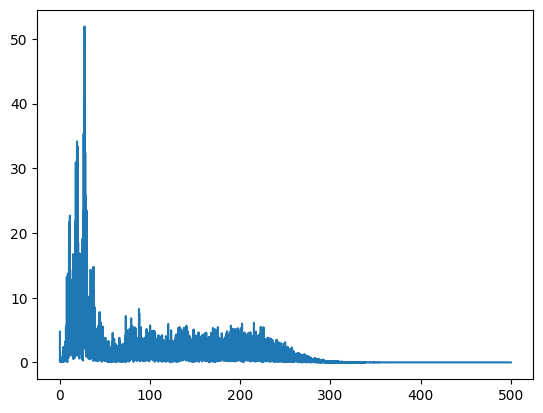

In [45]:
plt.plot(frequencies, np.abs(spectra[0]))

In [8]:
N = int(0.33/ (frequencies[1] - frequencies[0]))

running_avg = ss.fftconvolve(np.abs(spectra), np.ones((len(spectra), N))/N, mode='same', axes=1)

In [47]:
running_avg = np.convolve(np.abs(spectra[0]), np.ones(N)/N, mode='same')

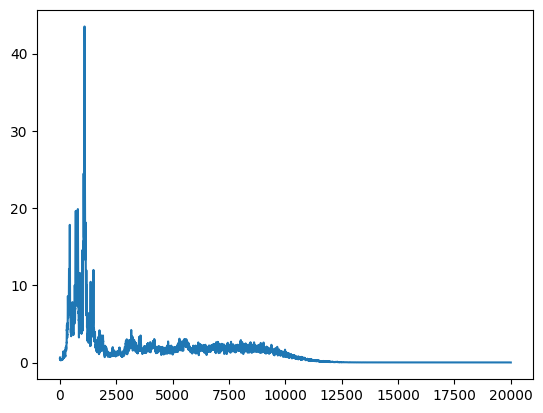

In [48]:
plt.plot(running_avg.real)

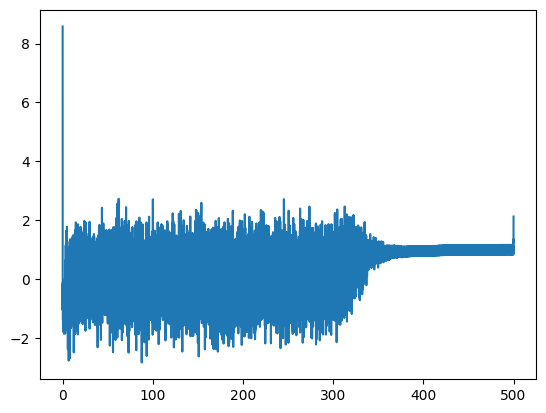

In [49]:
plt.plot(frequencies, spectra[0].real/running_avg)

In [9]:
whitened = spectra/running_avg

whitened_time = np.fft.irfft(whitened)

N = int(1.25 * sampling_rate)

running_avg = ss.fftconvolve(np.abs(whitened_time), np.ones((len(whitened_time), N))/N, mode='same', axes=1)

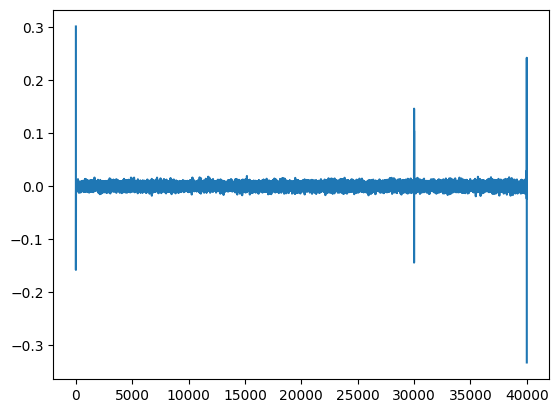

In [31]:
plt.plot(np.fft.irfft(whitened))

In [77]:
N = int(1.25 * sampling_rate)
running_avg = np.convolve(np.abs(np.fft.irfft(whitened)), np.ones(N)/N, mode='same')
# temp_normalization = 

ValueError: object too deep for desired array

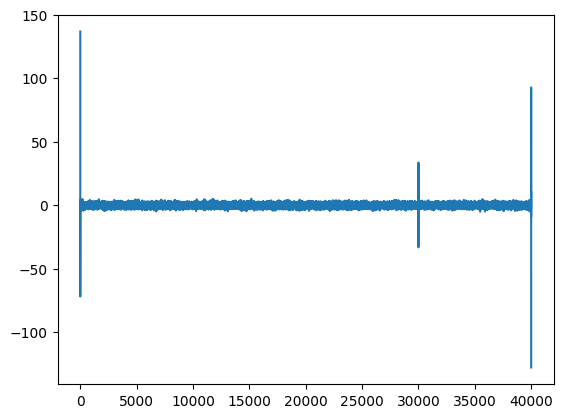

In [41]:
plt.plot(np.fft.irfft(whitened)/running_avg)

In [10]:
preprocessed = whitened_time/running_avg

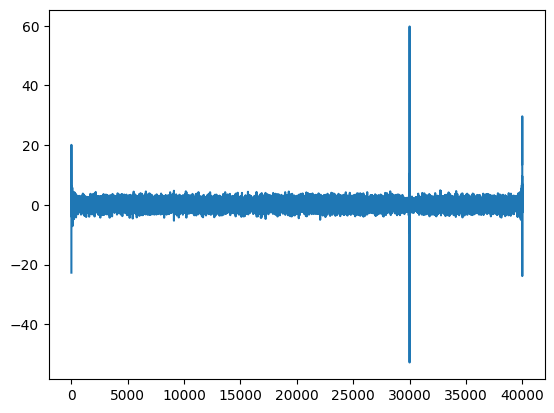

In [61]:
plt.plot(preprocessed[35])

In [1]:
subwindow_len = 1
overlap = 0.5

In [11]:
covariance, frequencies = f.covariance(
    preprocessed,
    subwindow_len,
    overlap,
    sample_interval=0.001,
)

In [12]:
num_frames = covariance.shape[0]
eig_ratios_covariance = np.empty(num_frames)

for d in range(num_frames):
    eigenvals, _ = np.linalg.eig(covariance[d])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios_covariance[d] = eigenvals[0] / np.sum(eigenvals)

C:\Users\issah\AppData\Local\Temp\ipykernel_32500\2718592155.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  eig_ratios_covariance[d] = eigenvals[0] / np.sum(eigenvals)


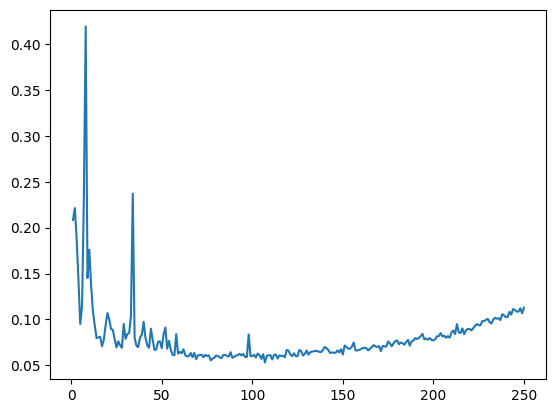

In [13]:
plt.plot(frequencies[1:-250], eig_ratios_covariance[1:-250])

In [14]:
coherence, frequencies = f.welch_coherence(
    data[start_ch : nchannels + start_ch : int(nchannels / nsensors)],
    subwindow_len,
    overlap,
    sample_interval=0.001,
)
eig_ratios_coherence = np.empty(num_frames)
for d in range(num_frames):
    eigenvals, _ = np.linalg.eig(coherence[d])
    eigenvals = np.sort(eigenvals)[::-1]
    eig_ratios_coherence[d] = eigenvals[0] / np.sum(eigenvals)

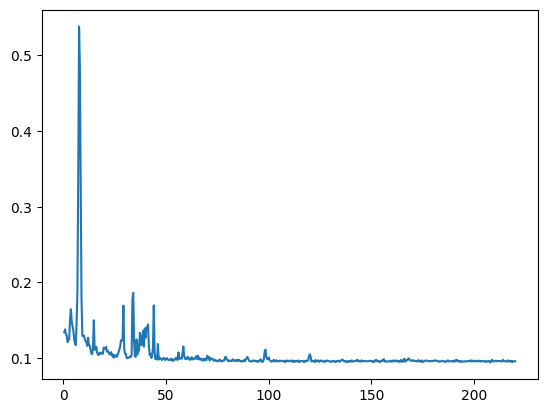

In [87]:
plt.plot(frequencies[1:-700], eig_ratios_coherence[1:-700])

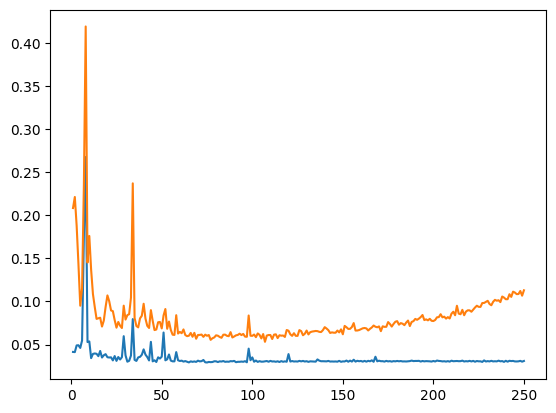

In [15]:
plt.plot(frequencies[1:-250], eig_ratios_coherence[1:-250])
plt.plot(frequencies[1:-250], eig_ratios_covariance[1:-250])